# SLG analysis



## Notebook setup

In [86]:
import project_utils
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import graphviz
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import xarray as xr
import seaborn as sns
import pandas as pd
import time

import pymc as pm 
import pymc_bart as pmb
import pytensor
import pytensor.tensor as pt

from pymc_bart.split_rules import ContinuousSplitRule, SubsetSplitRule
from scipy.special import logit
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
from sklearn.metrics import (
    mean_absolute_percentage_error
)
from warnings import filterwarnings
filterwarnings("ignore", category=UserWarning, module="pymc")

DATA_FILE = './data/cohorts_slg.csv'

In [2]:
df = pd.read_csv(DATA_FILE)
df['DATE_KEY'] = pd.to_datetime(df['DATE_KEY'])
df

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,GROSS_REVENUE,NET_REVENUE,REFUNDS,FULL_REVENUE
0,6.279211e+12,4624920477869,2022-11-20,2022-11-20 10:32:05,403.0,403.00,-186.45,216.55
1,6.279211e+12,4626755420333,2022-11-21,2022-11-21 10:33:03,199.0,199.00,-186.45,12.55
2,6.279211e+12,4696470847661,2022-12-28,2022-12-28 12:38:12,498.0,498.00,0.00,498.00
3,6.279213e+12,4624917954733,2022-11-20,2022-11-20 10:30:36,249.0,249.00,0.00,249.00
4,6.279238e+12,4624954425517,2022-11-20,2022-11-20 10:53:53,299.0,299.00,0.00,299.00
...,...,...,...,...,...,...,...,...
493711,6.679648e+12,5084212494509,2023-09-17,2023-09-17 19:14:09,425.0,361.25,0.00,361.25
493712,6.679648e+12,5886838931629,2024-12-01,2024-12-01 16:20:32,291.0,246.00,0.00,246.00
493713,6.679685e+12,5084251029677,2023-09-17,2023-09-17 19:55:18,365.0,365.00,0.00,365.00
493714,6.679685e+12,5285232771245,2024-01-03,2024-01-03 15:22:41,394.0,349.00,0.00,349.00


## EDA

Seems like we have quality data from 2021 onwards. We see strong seasonality effects and end-of-year seasonal peaks.

/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_75414/779287544.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


Text(0.5, 1.0, 'Revenue over time')

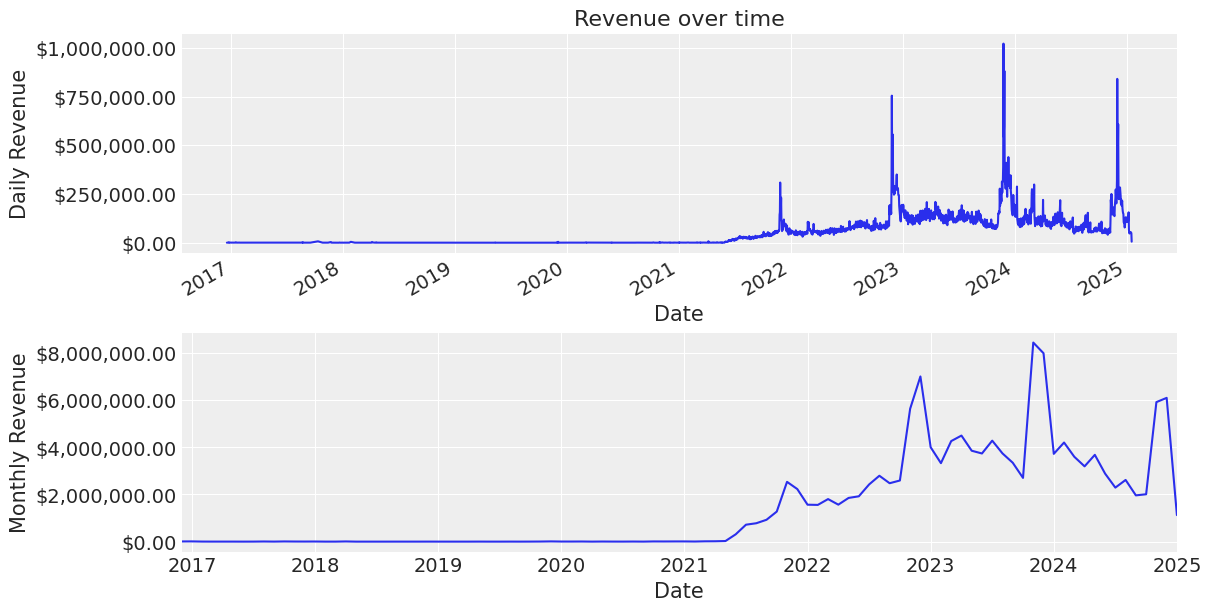

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6),)

df.groupby(
    'DATE_KEY'
)['FULL_REVENUE'].sum().plot(
    ax = axes[0],
)

(
    df.groupby('DATE_KEY')['FULL_REVENUE']
    .sum()
    .resample("M")
    .sum()
    .plot(ax = axes[1])
)

axes[0].yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.2f}"))
axes[1].yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.2f}"))
axes[0].set_xlabel('Date')
axes[1].set_xlabel('Date')
axes[0].set_ylabel('Daily Revenue')
axes[1].set_ylabel('Monthly Revenue')

axes[0].set_title("Revenue over time")

/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_75414/2301353138.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


Text(0.5, 1.0, 'Order count over time')

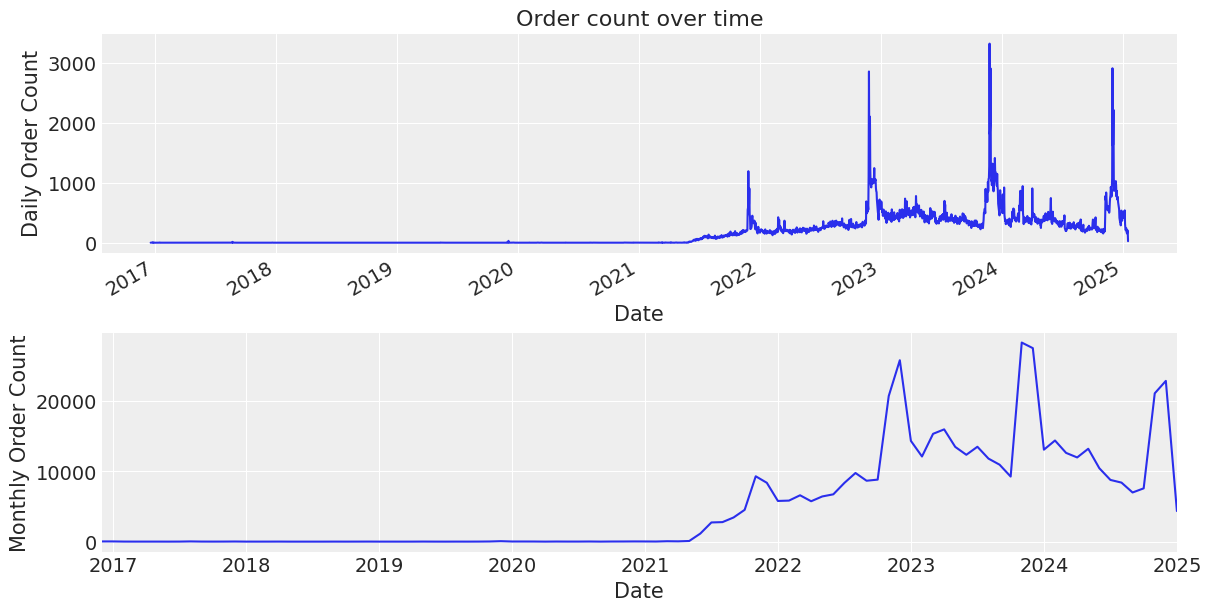

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6),)

df.groupby(
    'DATE_KEY'
)['ORDER_KEY'].nunique().plot(
    ax = axes[0],
)

(
    df.groupby('DATE_KEY')['ORDER_KEY']
    .nunique()
    .resample("M")
    .sum()
    .plot(ax = axes[1])
)

# axes[0].yaxis.set_major_formatter(mtick.StrMethodFormatter("{:,.2f}"))
# axes[1].yaxis.set_major_formatter(mtick.StrMethodFormatter("{:,.2f}"))
axes[0].set_xlabel('Date')
axes[1].set_xlabel('Date')
axes[0].set_ylabel('Daily Order Count')
axes[1].set_ylabel('Monthly Order Count')

axes[0].set_title("Order count over time")

Text(0.5, 1.0, 'Number of transactions per customer (Log scale)')

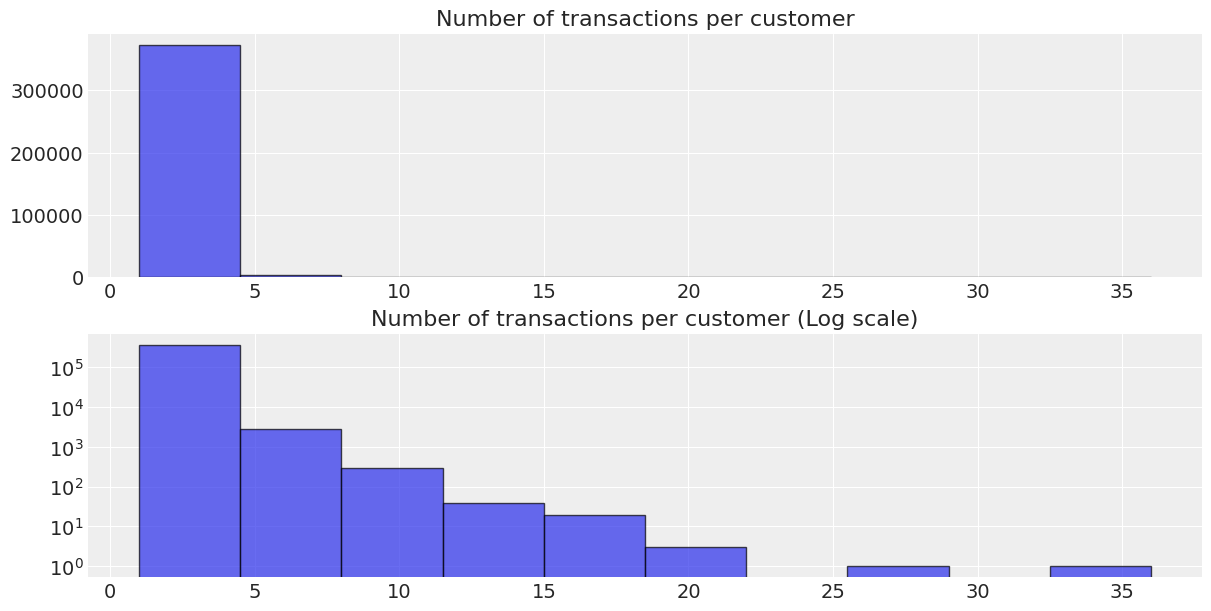

In [5]:
fig, axes = plt.subplots(2, 1, figsize = (12, 6))
(
    df.groupby('CUSTOMER_KEY')['ORDER_KEY']
    .nunique()
    .hist(
        ax = axes[0],
        edgecolor = 'black',
        alpha = .7
    )
)

axes[0].set_title("Number of transactions per customer")

(
    df.groupby('CUSTOMER_KEY')['ORDER_KEY']
    .nunique()
    .hist(
        ax = axes[1],
        log = True,
        edgecolor = 'black',
        alpha = .7
    )
)

axes[1].set_title("Number of transactions per customer (Log scale)")



In [6]:
print(f"Number of unique customers {df['CUSTOMER_KEY'].nunique()}")

Number of unique customers 375591


In [7]:
transactions_df = project_utils.load_transactions(DATA_FILE)
transactions_df = project_utils.preprocess_transactions(transactions_df)
transactions_df

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,GROSS_REVENUE,NET_REVENUE,REFUNDS,FULL_REVENUE,WEEK,MONTH,COHORT
0,6279210827949.0,4624920477869,2022-11-20,2022-11-20 10:32:05,403.0,403.00,-186.45,216.55,2022-11-14,2022-11-01,2022-11-01
1,6279210827949.0,4626755420333,2022-11-21,2022-11-21 10:33:03,199.0,199.00,-186.45,12.55,2022-11-21,2022-11-01,2022-11-01
2,6279210827949.0,4696470847661,2022-12-28,2022-12-28 12:38:12,498.0,498.00,0.00,498.00,2022-12-26,2022-12-01,2022-11-01
3,6279212531885.0,4624917954733,2022-11-20,2022-11-20 10:30:36,249.0,249.00,0.00,249.00,2022-11-14,2022-11-01,2022-11-01
4,6279237861549.0,4624954425517,2022-11-20,2022-11-20 10:53:53,299.0,299.00,0.00,299.00,2022-11-14,2022-11-01,2022-11-01
...,...,...,...,...,...,...,...,...,...,...,...
493711,6679647879341.0,5084212494509,2023-09-17,2023-09-17 19:14:09,425.0,361.25,0.00,361.25,2023-09-11,2023-09-01,2023-09-01
493712,6679647879341.0,5886838931629,2024-12-01,2024-12-01 16:20:32,291.0,246.00,0.00,246.00,2024-11-25,2024-12-01,2023-09-01
493713,6679684776109.0,5084251029677,2023-09-17,2023-09-17 19:55:18,365.0,365.00,0.00,365.00,2023-09-11,2023-09-01,2023-09-01
493714,6679684776109.0,5285232771245,2024-01-03,2024-01-03 15:22:41,394.0,349.00,0.00,349.00,2024-01-01,2024-01-01,2023-09-01


In [8]:
transactions_df = transactions_df[
    transactions_df['DATE_KEY'] > "2021-01-01"
]
transactions_df

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,GROSS_REVENUE,NET_REVENUE,REFUNDS,FULL_REVENUE,WEEK,MONTH,COHORT
0,6279210827949.0,4624920477869,2022-11-20,2022-11-20 10:32:05,403.0,403.00,-186.45,216.55,2022-11-14,2022-11-01,2022-11-01
1,6279210827949.0,4626755420333,2022-11-21,2022-11-21 10:33:03,199.0,199.00,-186.45,12.55,2022-11-21,2022-11-01,2022-11-01
2,6279210827949.0,4696470847661,2022-12-28,2022-12-28 12:38:12,498.0,498.00,0.00,498.00,2022-12-26,2022-12-01,2022-11-01
3,6279212531885.0,4624917954733,2022-11-20,2022-11-20 10:30:36,249.0,249.00,0.00,249.00,2022-11-14,2022-11-01,2022-11-01
4,6279237861549.0,4624954425517,2022-11-20,2022-11-20 10:53:53,299.0,299.00,0.00,299.00,2022-11-14,2022-11-01,2022-11-01
...,...,...,...,...,...,...,...,...,...,...,...
493711,6679647879341.0,5084212494509,2023-09-17,2023-09-17 19:14:09,425.0,361.25,0.00,361.25,2023-09-11,2023-09-01,2023-09-01
493712,6679647879341.0,5886838931629,2024-12-01,2024-12-01 16:20:32,291.0,246.00,0.00,246.00,2024-11-25,2024-12-01,2023-09-01
493713,6679684776109.0,5084251029677,2023-09-17,2023-09-17 19:55:18,365.0,365.00,0.00,365.00,2023-09-11,2023-09-01,2023-09-01
493714,6679684776109.0,5285232771245,2024-01-03,2024-01-03 15:22:41,394.0,349.00,0.00,349.00,2024-01-01,2024-01-01,2023-09-01


In [9]:
cohort_df = project_utils.preprocess_transactions_to_cohort(
    transactions_df
)

cohort_df

,cohort,period,n_active_users,revenue,n_users,age,cohort_age,retention,revenue_per_user,revenue_per_active_user
0,2021-01-01,2021-01-01,20.0,8088.63,22.0,1475.0,0.0,0.909091,367.665000,404.4315
1,2021-01-01,2021-09-01,1.0,0.00,22.0,1475.0,243.0,0.045455,0.000000,0.0000
2,2021-01-01,2021-12-01,1.0,648.00,22.0,1475.0,334.0,0.045455,29.454545,648.0000
3,2021-01-01,2022-02-01,2.0,294.00,22.0,1475.0,396.0,0.090909,13.363636,147.0000
4,2021-01-01,2022-04-01,1.0,0.00,22.0,1475.0,455.0,0.045455,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...
1695,2025-01-01,2025-09-01,NaN,NaN,2625.0,14.0,243.0,NaN,NaN,NaN
1696,2025-01-01,2025-10-01,NaN,NaN,2625.0,14.0,273.0,NaN,NaN,NaN
1697,2025-01-01,2025-11-01,NaN,NaN,2625.0,14.0,304.0,NaN,NaN,NaN
1698,2025-01-01,2025-12-01,NaN,NaN,2625.0,14.0,334.0,NaN,NaN,NaN


Text(0.5, 1.0, 'Cohort size')

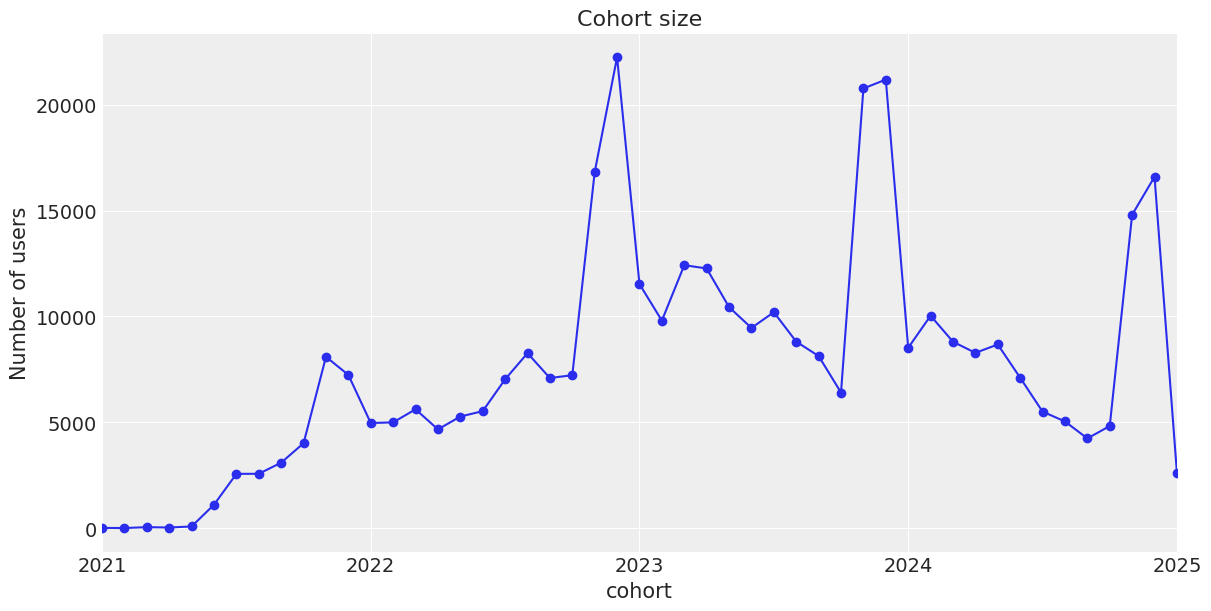

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
(
    cohort_df.groupby('cohort')['n_users']
    .max()
    .plot(marker = 'o')
)

ax.set_ylabel('Number of users')
ax.set_title("Cohort size")

Retention seems very poor across all cohorts, regardless of time of acquisition.

<Axes: xlabel='period', ylabel='cohort'>

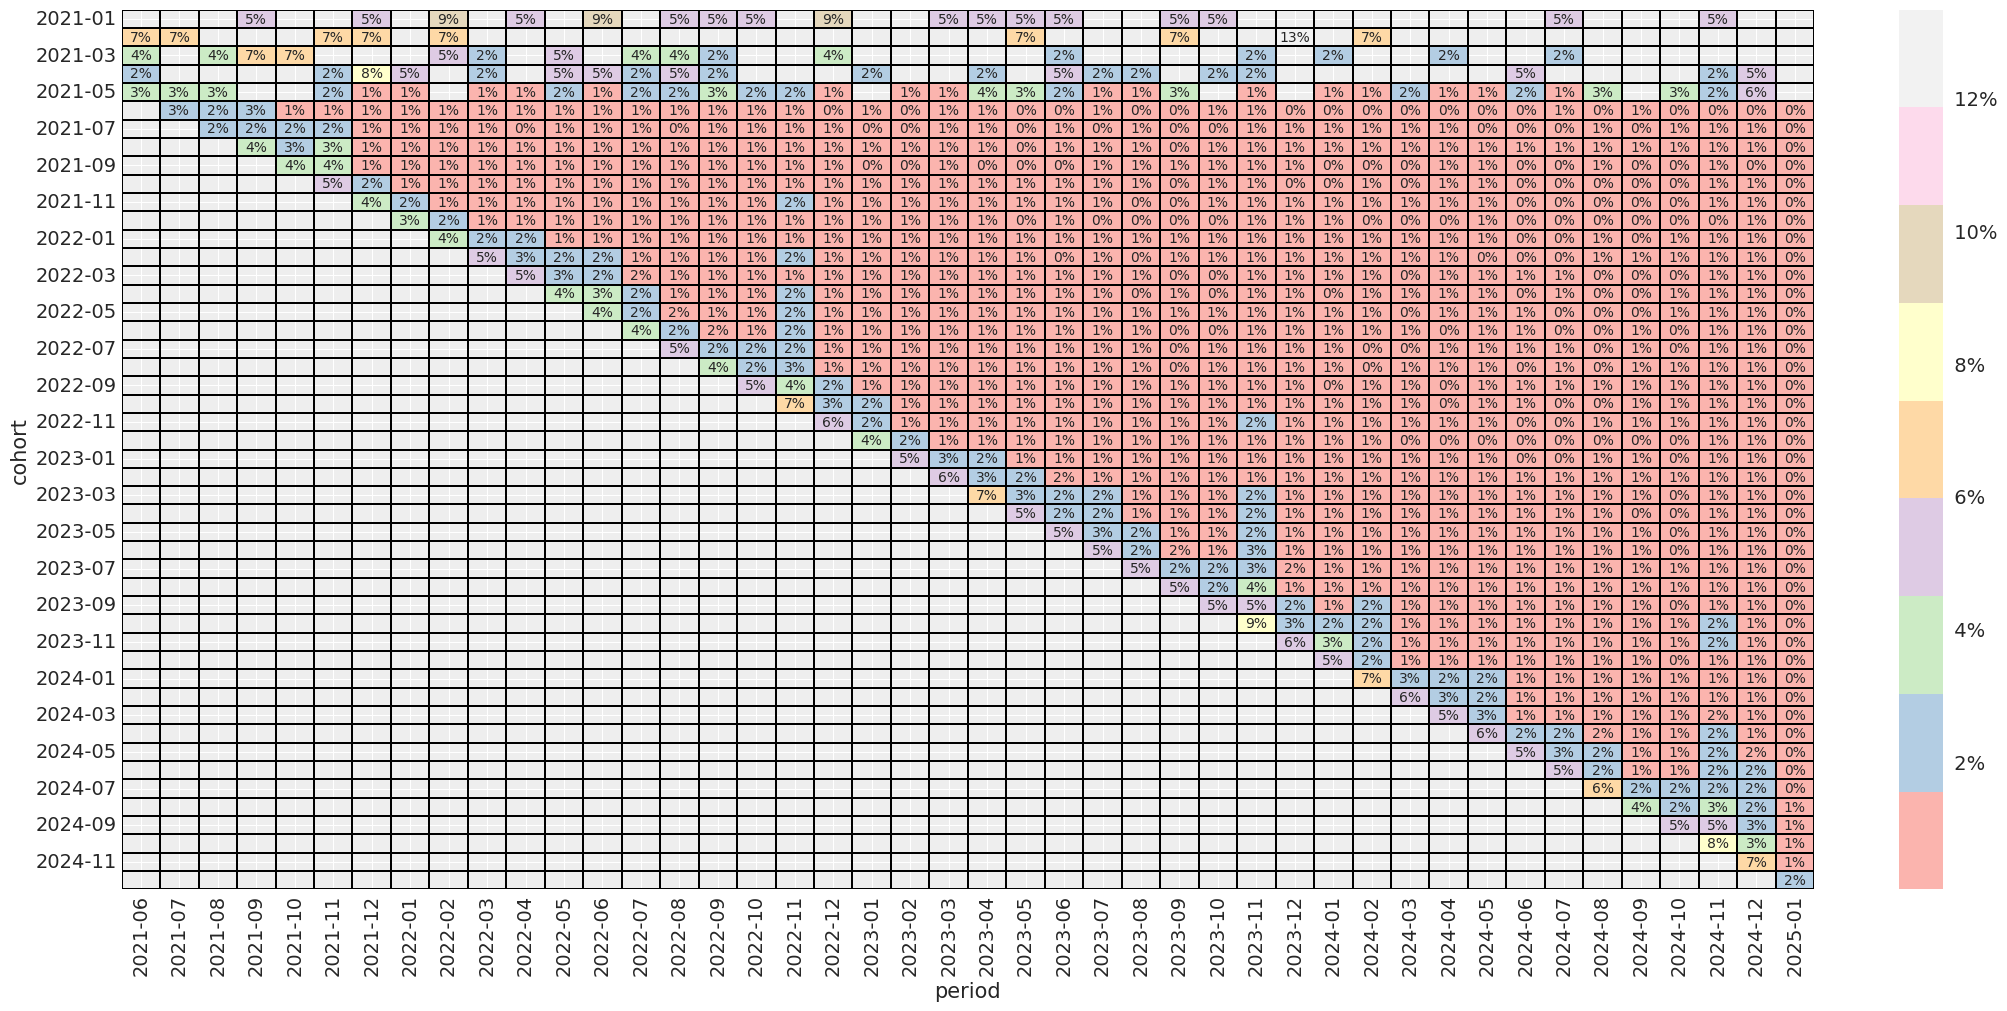

In [11]:
fig, ax = plt.subplots(figsize = (20, 10))
fmt = lambda x, _ : f"{x: 0.0%}"
max_cohort = cohort_df['cohort'].max().strftime("%Y-%m-%d")

cohort_df.assign(
    cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
    period=lambda df: df["period"].dt.strftime("%Y-%m"),
).query(
        "cohort_age != 0 & period < @max_cohort" 
).filter(
    ["cohort", "period", "retention"]
).pivot(
    index = "cohort",
    columns = "period",
    values = "retention"
).pipe(
    (sns.heatmap, "data"),
    cmap="Pastel1",
    linewidths=0.2,
    linecolor="black",
    annot=True,
    fmt="0.0%",
    cbar_kws={"format": mtick.FuncFormatter(fmt)},
    ax=ax,
)

## Model Fitting

In [80]:
transactions_df = project_utils.load_transactions(DATA_FILE, sample_start_date="2021-01-01")
transactions_df = project_utils.preprocess_transactions(transactions_df)
cohort_df = project_utils.preprocess_transactions_to_cohort(
    transactions_df,
    project_out_of_sample=True
)
cohort_df = cohort_df.fillna(0)

In [81]:
start_time = time.time()

date_range = pd.date_range(
    cohort_df['cohort'].min(),
    cohort_df['cohort'].max(),
    freq = '1M'
)

cutoff = "2025-01-01"
train_df, test_df = project_utils.custom_train_test_split(
    cutoff, cohort_df, 
)

train_features = project_utils.preprocess_train_test_data(
    train_df, "train", 
)
model = project_utils.build_new_model(train_features, use_default_priors=True)
model, idata, pos_predictive = project_utils.fit_model(model)

test_features = project_utils.preprocess_train_test_data(
    test_df,
    mode = "test",
    seen_cohorts = train_features['cohorts'],
    cohort_encoder = train_features['cohort_encoder'],
    age_scaler = train_features['age_scaler'],
    cohort_age_scaler= train_features['cohort_age_scaler']
)

model, idata = project_utils.draw_new_predictions(
    model,
    test_features,
    idata
)

combined_data, _, __ = project_utils.process_idata_posterior_predictive_for_plotting(
    idata = idata,
    posterior_predictive=pos_predictive,
    train_data_red_df=train_features['data_red_df'],
    test_data_red_df=test_features['data_red_df']
)

end_time = time.time()

time_taken = end_time - start_time

print("==========" * 10)
print(f"One model fit took {time_taken:.4f}")
print(f"Full backtest (monthly frequency) takes {time_taken * date_range.shape[0] / 60 :.2f} minutes (estimated)")
print("==========" * 10)

/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_75414/2198575631.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

One model fit took 99.3505
Full backtest (monthly frequency) takes 79.48 minutes (estimated)


/Users/fanghema/Desktop/Revenue Retention Project/project_utils.py:1063: UserWarning: The figure layout has changed to tight
  plt.savefig(save_file_path)


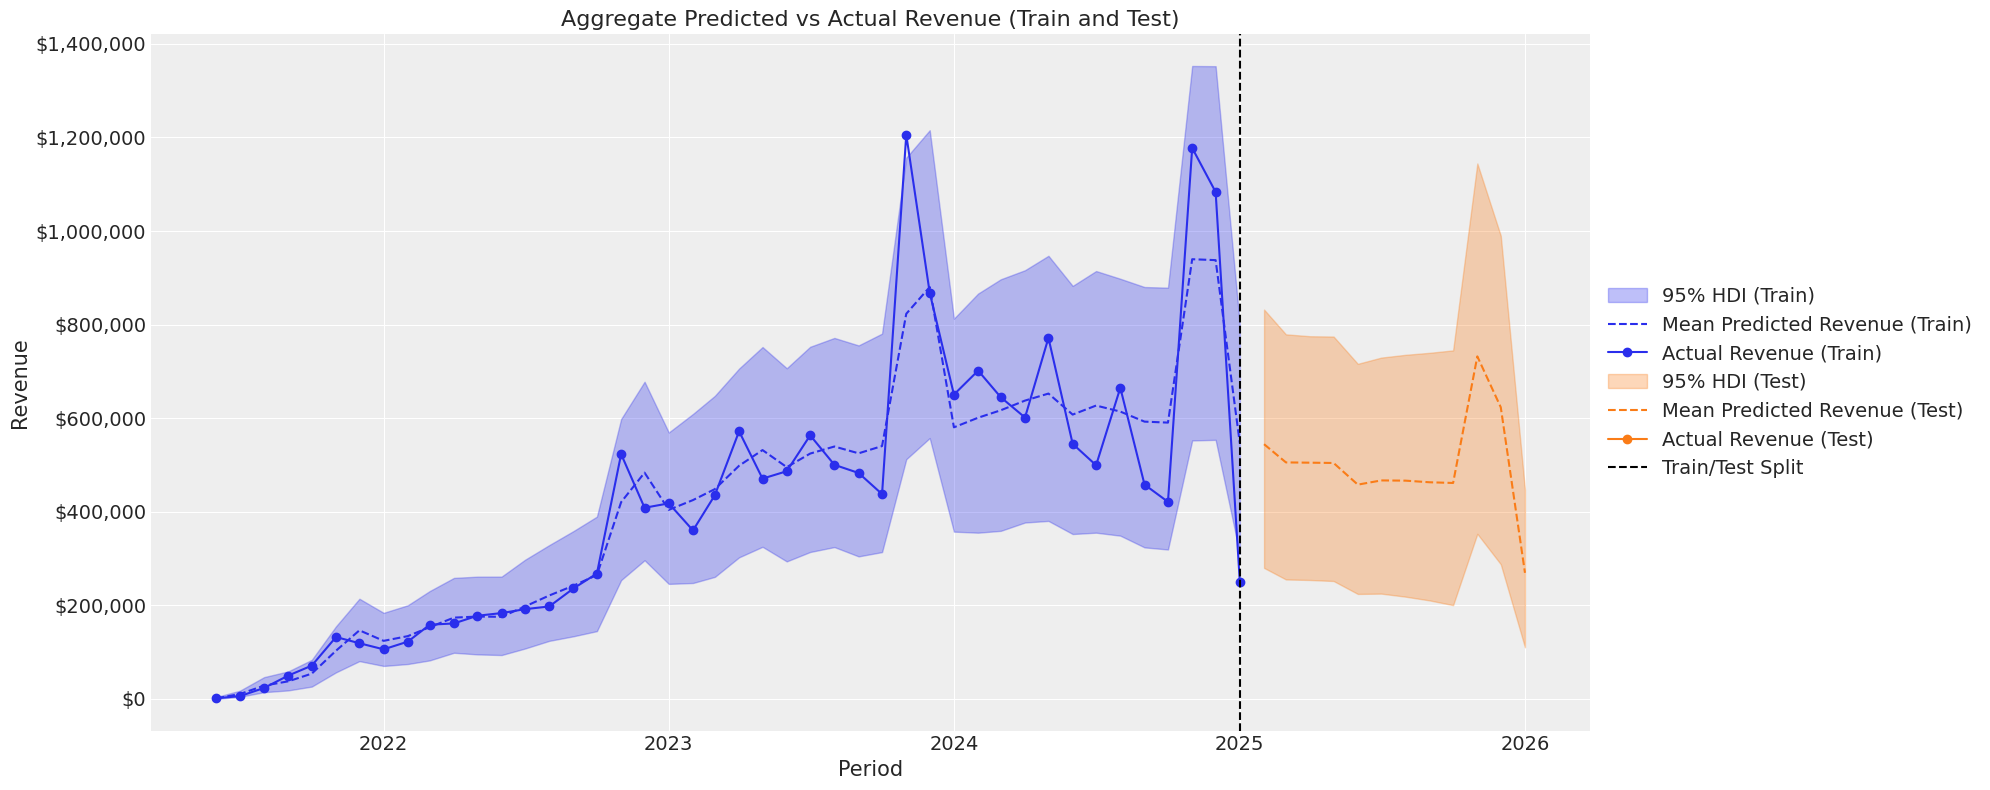

In [89]:
project_utils.plot_monthly_revenue(combined_data.reset_index())

## Full backtest

In [91]:
log_file_path = './model logs/slg_log_2.csv'

log_df = pd.DataFrame(
    columns = [
        'Dataset', 
        'Predicted Revenue', 
        'Actual Revenue', 
        'hdi_lower',
        'hdi_upper', 
        'cutoff'
    ]
)
log_df.to_csv(log_file_path)

In [ ]:
for i, cutoff in enumerate(date_range):
    cutoff = datetime.datetime.strftime(cutoff, format = "%Y-%m-%d")
    print(f"Processing {cutoff}")

    try: 
        train_df, test_df = project_utils.custom_train_test_split(cutoff, cohort_df)
        train_features = project_utils.preprocess_train_test_data(train_df, mode = "train")

        model = project_utils.build_new_model(train_features, use_default_priors=True)

        model, idata, pos_predictive = project_utils.fit_model(model)

        latest_posteriors = project_utils.extract_posteriors(idata)

        test_features = project_utils.preprocess_train_test_data(
            test_df,
            mode="test",
            seen_cohorts = train_features['cohorts'],
            cohort_encoder = train_features['cohort_encoder'],
            age_scaler = train_features['age_scaler'],
            cohort_age_scaler= train_features['cohort_age_scaler']
        )
        model, idata = project_utils.draw_new_predictions(model, test_features, idata)

        combined_data, _, __ = project_utils.process_idata_posterior_predictive_for_plotting(
            idata = idata,
            posterior_predictive=pos_predictive,
            train_data_red_df=train_features['data_red_df'],
            test_data_red_df=test_features['data_red_df']
        )
        combined_data['cutoff'] = [cutoff for _ in range(combined_data.shape[0])]
        combined_data.reset_index(inplace=True)

        log_df = pd.read_csv(log_file_path, index_col=0)
        log_df = pd.concat([log_df, combined_data], ignore_index=True)
        log_df.to_csv(log_file_path)

    except Exception as e:
        print(f"Encountered exception {e}")
        print(f"Moving on to next iteration")
        continue


Processing 2021-01-31
Encountered exception Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MaxAbsScaler.
Moving on to next iteration
Processing 2021-02-28
Encountered exception Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MaxAbsScaler.
Moving on to next iteration
Processing 2021-03-31
Encountered exception Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MaxAbsScaler.
Moving on to next iteration
Processing 2021-04-30
Encountered exception Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MaxAbsScaler.
Moving on to next iteration
Processing 2021-05-31
Encountered exception Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MaxAbsScaler.
Moving on to next iteration
Processing 2021-06-30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
/Users/fanghema/Library/Caches/pypoetry/virtualenvs/deep_ocean_-_bart-Vly4tlAG-py3.11/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2021-07-31


/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_75414/408828629.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, combined_data], ignore_index=True)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2021-08-31


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

Processing 2021-09-30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

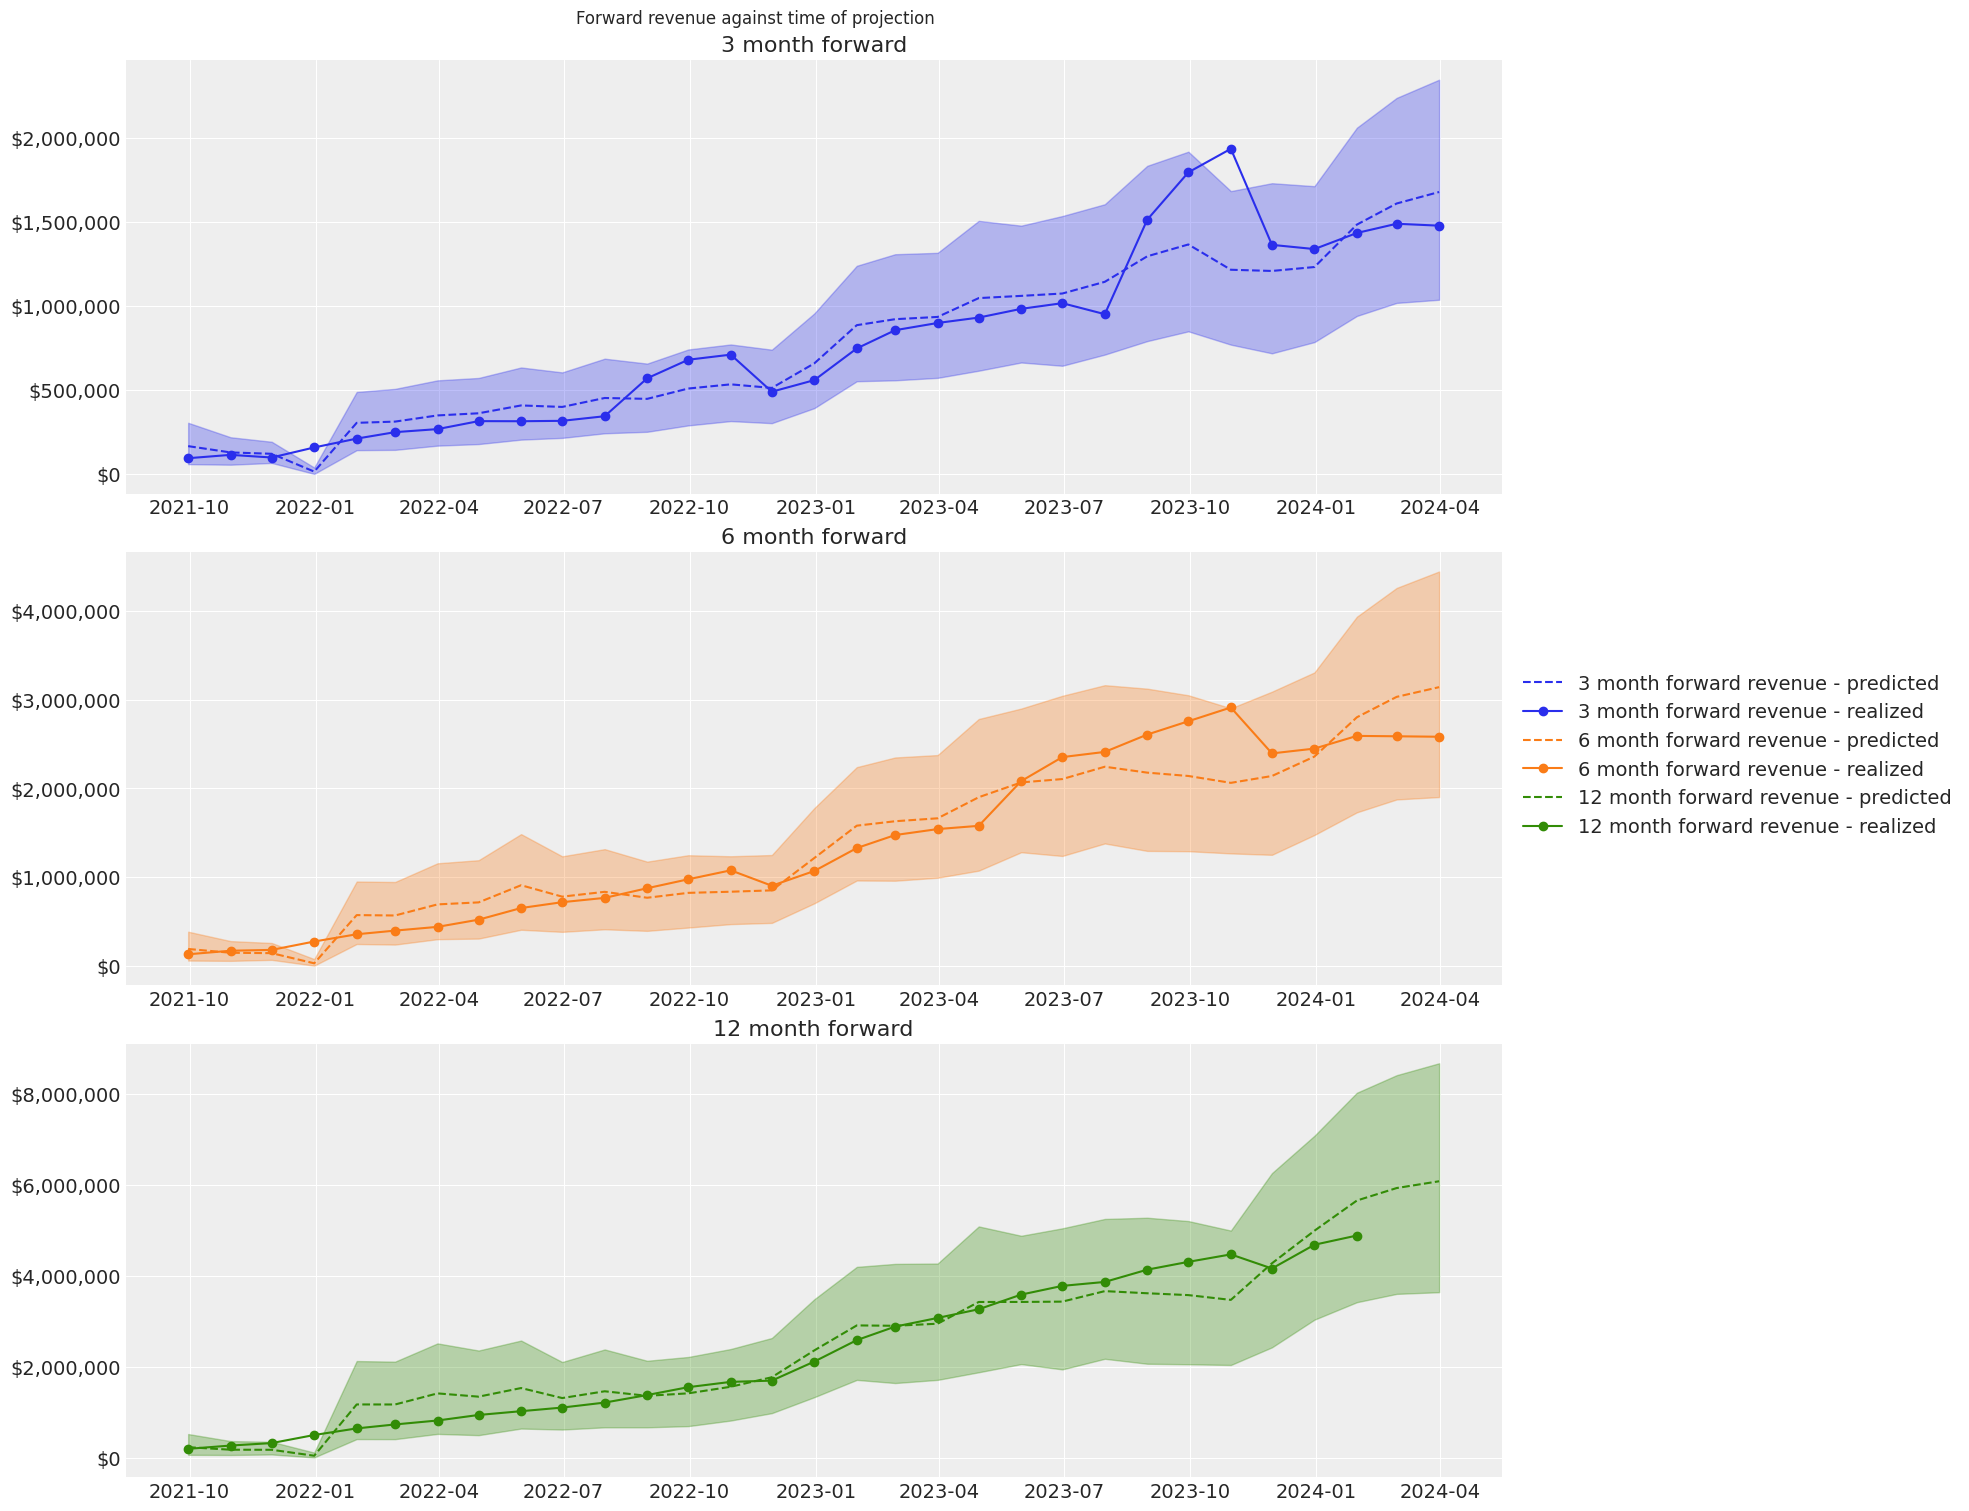

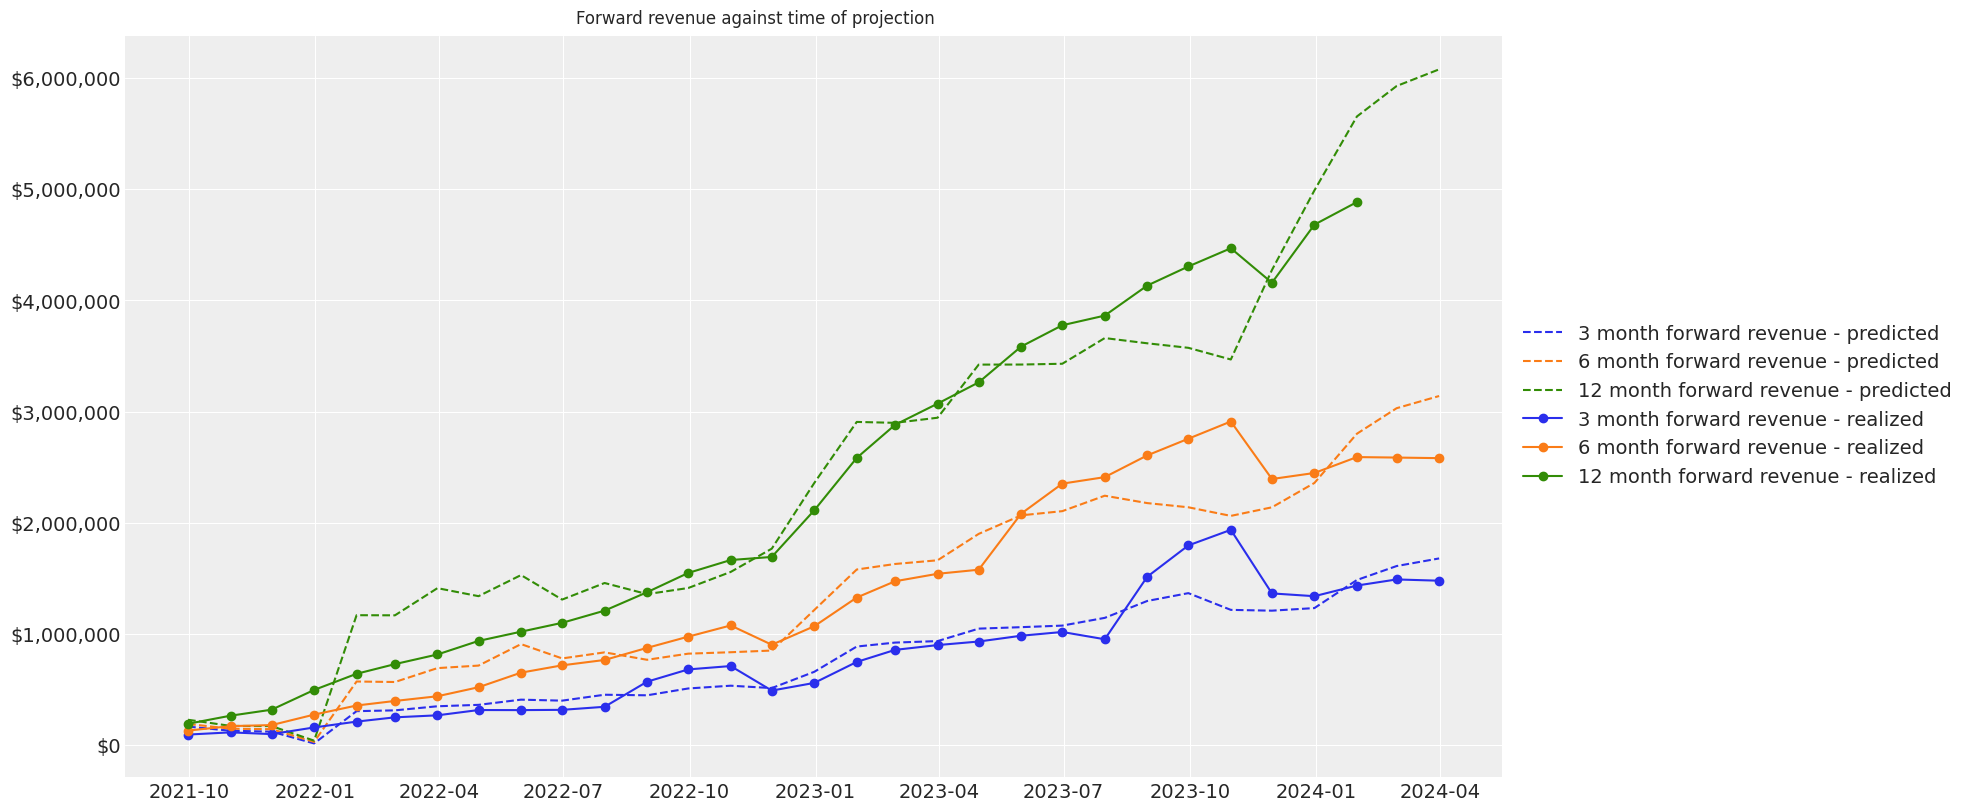

In [ ]:
log_df = pd.read_csv("model logs/slg_log_2.csv", index_col=0)

log_df['period'] = pd.to_datetime(log_df['period'], format = "mixed")
log_df['cutoff'] = pd.to_datetime(log_df['cutoff'], format = "mixed")

forward_revenue = project_utils.calculate_forward_revenue(log_df, months = [3, 6, 12])

evaluations = project_utils.evaluate_predictions(log_df)

project_utils.plot_forward_revenue(forward_revenue=forward_revenue.iloc[3:, :], show_CI=True)
project_utils.plot_forward_revenue(forward_revenue=forward_revenue.iloc[3:, :], show_CI=False)

In [ ]:
forward_revenue.to_csv(
    "./forward revenue/forward_revenue_slg.csv"
)